# Austin Animal K-Means Clustering Project

## Project Goals & Outline

This notebook explores animal intake data from the *Austin Animal Center* using clustering. My goal was to identify **meaningful groups using K-Means clustering**.






Techniques used:

*   Categorical preprocessing (simplifying the Austin Animal Shelter dataset)
  * binning ages
  * **one-hot encoding**
*   Feature scaling
*   Identifying optimal k
  * Initially by analyzing **silhouette scores**,
  * then by cluster profiling with **Z-scores**
*   **KMeans clustering**

## 1. Import and Load Data

In [ ]:
# Install kneed for elbow method used later on
!pip install kneed

# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from kneed import KneeLocator

In [ ]:
# Link to raw CSV file on GitHub
data_url = 'https://raw.githubusercontent.com/hyeeunkg/Austin-Animal-Clustering/refs/heads/main/aac_intakes.csv?token=GHSAT0AAAAAADFN2XRKDPWPH7B7UR3YFC2K2COISUA'
df = pd.read_csv(data_url)

## 2. Inspect & Explore Data

In [ ]:
# Quick overview

print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')
print('\nFirst few columns:\n', df.columns[:5].tolist())
df.sample(3)

Rows: 80187, Columns: 12

First few columns:
 ['age_upon_intake', 'animal_id', 'animal_type', 'breed', 'color']


,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake
13177,1 year,A723255,Other,Bat Mix,Brown,2016-03-29T00:11:00.000,2016-03-29T00:11:00.000,Lonestar Dr in Travis (TX),Sick,Wildlife,NaN,Unknown
10664,2 years,A697910,Cat,Domestic Medium Hair Mix,Orange Tabby/White,2015-06-15T14:20:00.000,2015-06-15T14:20:00.000,Austin (TX),Normal,Public Assist,Boris,Neutered Male
3577,1 month,A756839,Dog,Chihuahua Shorthair Mix,White/Tan,2017-08-26T10:35:00.000,2017-08-26T10:35:00.000,Braker And I35 in Austin (TX),Normal,Stray,NaN,Intact Female


## 3. Exploring the Data

In [ ]:
# Visualize cardinality of features
df.nunique()

,0
age_upon_intake,46
animal_id,72365
animal_type,5
breed,2166
color,529
datetime,57055
datetime2,57055
found_location,36772
intake_condition,8
intake_type,5


### Distribution Plots

To best engineer features and assess clustering strategies, I first explored the distribution of key categorical features related to animal intake.

*  `animal_type`: The data primarily includes Dogs and Cats, with a smaller number of species marked as Other as well as Birds and Livestock.
  * This initial distribution made me consider combining minor categories to reduce sparsity.

*  `breed`: **High-cardinality** variable.
  * This helped determine the strong need to simplify, which was later adressed through grouping into broader categories.

*   `color`: Many unique values, making it difficult to discern.
  * Despite this, it was still explored but eventually ommitted from clustering due to high cardinality and limited impact on cluster separation.

*  `intake_condition`: Describes the animal's health/condition upon arrival. An overwhelming majority of animals were categorized as 'Normal' upon intake, with a very small proportion marked as being Injured, 'Sick', 'Nursing', 'Aged', etc.
  *   This imbalance suggested limited clustering utility and was later omitted from clustering.

*  Similarly, `intake_type`: Contain mostly Stray intakes, with much smaller proportions of 'Owner Surrender', 'Public Assists', 'Wildlife', and 'Euthanasia Request'.
  * This overrepresentation was later addressed to improve interpretability.

*  `sex_upon_intake`: This distribution was more balanced compared to other features, showing a mix of Fixed and Intact (for both males and females), and Unknown entries.

*  `age_upon_intake`: Displayed a long-tailed distribution.
  * Suggested the need to bin ages into more interpretable age groups during preprocessing.

In [ ]:
# Subset possibly relevant features for exploratory visualization
selected_cols = [
    'animal_type',
    'breed',
    'color',
    'intake_condition',
    'intake_type',
    'sex_upon_intake',
    'age_upon_intake'
    ]
df = df[selected_cols]

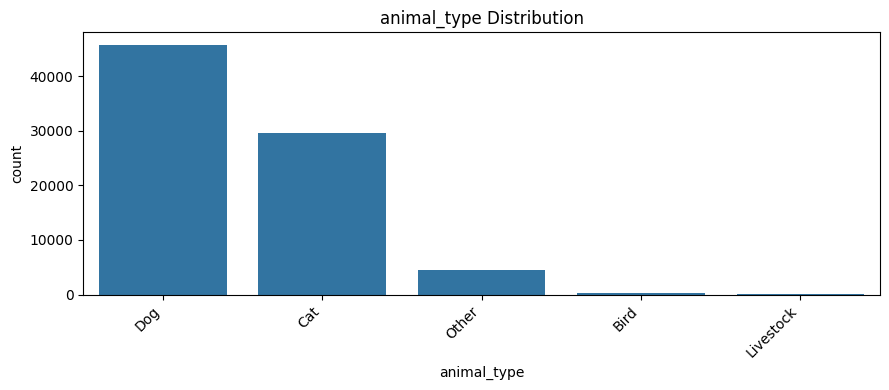

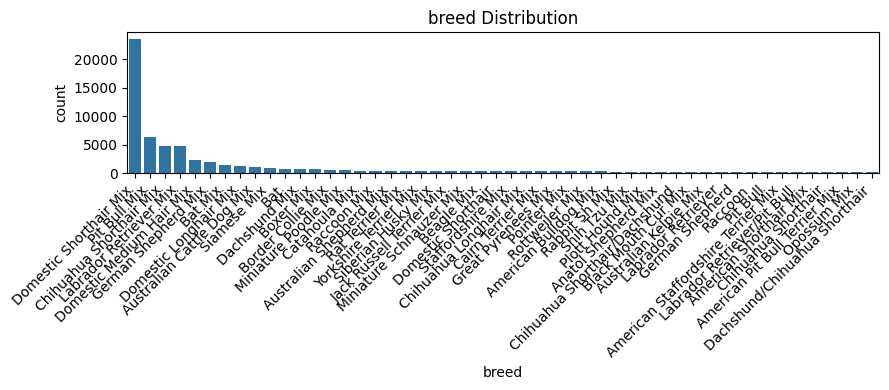

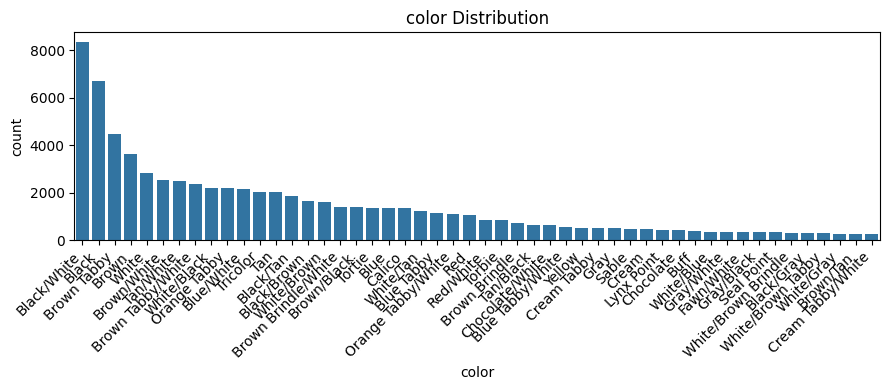

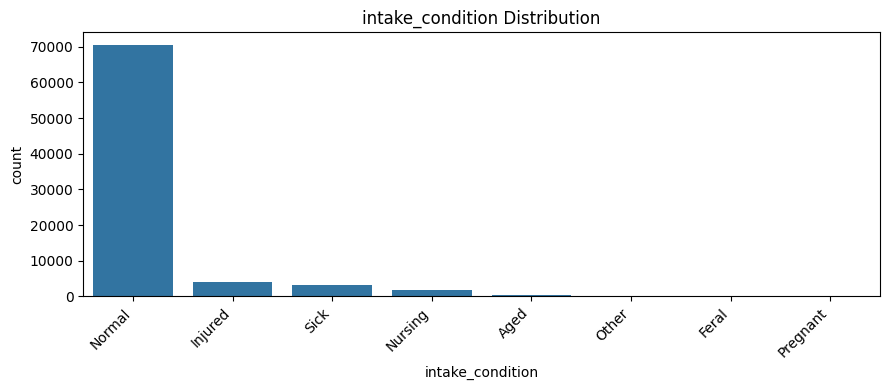

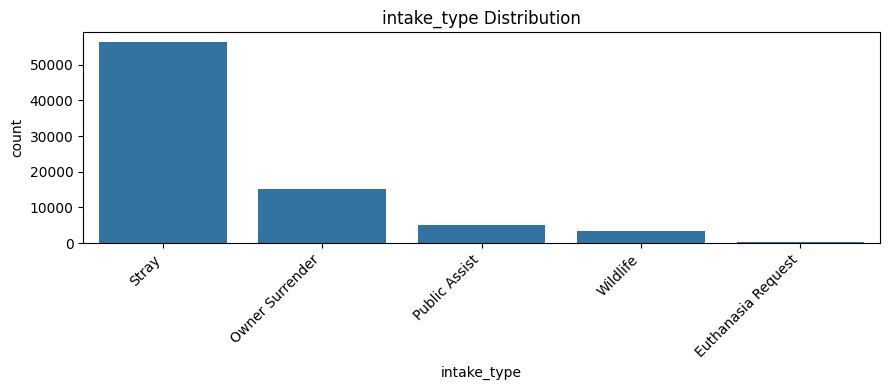

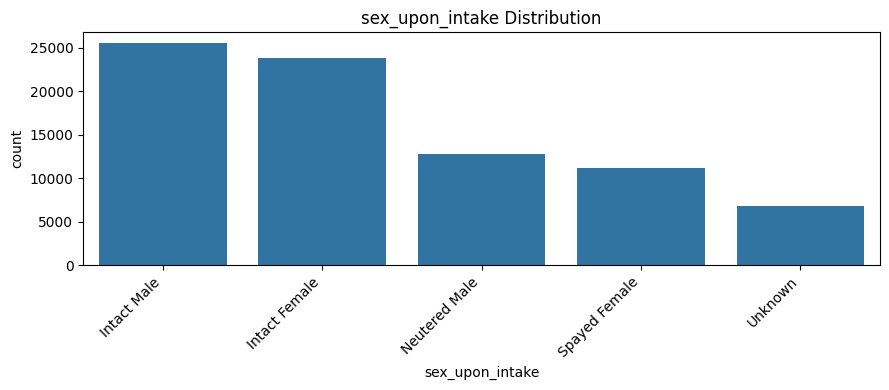

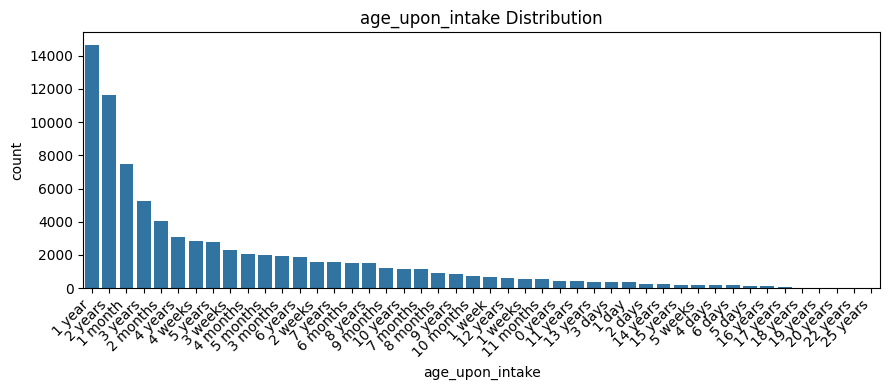

In [ ]:
categorical_cols = [
    'animal_type', 'breed', 'color',
    'intake_condition', 'intake_type',
    'sex_upon_intake', 'age_upon_intake'
    ]

for col in categorical_cols:
    plt.figure(figsize = (9, 4))
    sns.countplot(data = df, x = col, order = df[col].value_counts().index[:50])  # Limit long tail
    plt.title(f'{col} Distribution')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()

# 4. Data Cleaning and Feature Engineering

## Feature Selection Rationale




After viewing the distribution of animal intake data of the original dataset, I chose to focus on 6 features for clustering that seemed most relevant:


*   `age_upon_intake`
* `animal_type`
* `breed, color`
* `intake_condition` (ultimately removed from clustering)
* `intake_type`
* `sex_upon_intake`

These were chosen because they *directly relate* to an animal's **physical traits** or **intake context** (factors that could meaningfully separate clusters).

> Final decisions on whether to retain or drop variables were informed by threshold analysis and overall presence in cluster profiles.


Columns like `name`, `date_time`, and `found_location` were excluded due to lack of clustering relevance (high cardinality, time-based info that is more suitable for temporal analysis)

In [ ]:
# Core feature selection for clustering
selected_features = [
    'age_upon_intake',
    'animal_type',
    'breed',
    'intake_condition',
    'intake_type',
    'sex_upon_intake'
    ]

df = df[selected_features]

df = df.dropna()

## Simplify and Group Categories

In this section, I regrouped rare values under broader categories in order in hopes to proactively simplify one-hot encoding done after, and reduce dimensionality.

Based on EDA findings (and later cluster profile reviews), the following **feature transformations** were made:

*  `animal_type`: Regrouped into Dog, Cat, and Other (which includes birds, livestock, and other uncommon animals)

*  `breed`: Includes Mixed vs. Purebred.

*  `intake_type`: Regrouped into Stray vs. Other (less frequent categories combined).
  * Despite distribution imbalance, the feature was ultimately retained because it captured meaningful differences in how animals entered the system.

*  `sex_upon_intake`: Regrouped into Fixed (spayed/neutered), Intact (unspayed, unneutered), and Unknown.

*  `age_upon_intake`: Converted into a numeric form (in days) and then binned into age groups.

This helped to reduce noice, especially for features like `breed` that was quite varied.




> Note:

> `intake_condition` was initially regrouped into a binary variable: Normal vs. Needing Extra Care.
   *  However, due to such a disproportionately large Normal/healthy population, it was excluded from clustering since it added little discriminatory value.

In [ ]:
    # Group rare animal types into 'Other'
df['animal_type'] = df['animal_type'].apply(lambda x: 'Other' if x not in ['Dog', 'Cat'] else x)

    # Simplify breed into binary group
top_10_breeds = df['breed'].value_counts().nlargest(10).index
df['breed_grouped'] = df['breed'].apply(lambda x: x if x in top_10_breeds else 'Pure breed')
    # If breed name contains 'Mix' or '/', re-label as 'Mixed breed'
df['breed_binary'] = df['breed_grouped'].apply(lambda x: 'Mixed breed' if 'Mix' in x or '/' in x else x)

    # Group intake condition into 'Normal' vs. 'Needing Extra Care'
df['intake_condition'] = df['intake_condition'].apply(lambda x: 'Needing Extra Care' if x != 'Normal' else x)

    # Group intake type: Keep 'Stray', group others as 'Other'
df['intake_type'] = df['intake_type'].apply(lambda x: x if x == 'Stray' else 'Other')

In [ ]:
# Group sex status as 'Fixed', 'Intact' 'Unknown'
def simplify_sex(x):
    if pd.isnull(x):
        return 'Unknown'
    x = x.lower()
    if 'spayed' in x or 'neutered' in x:
        return 'Fixed'
    elif 'intact' in x:
        return 'Intact'
    else:
        return 'Unknown'

df['sex_grouped'] = df['sex_upon_intake'].apply(simplify_sex)

In [ ]:
# Drop unused original columns after preprocessing
df = df.drop(columns=['sex_upon_intake', 'breed', 'breed_grouped'])

### Convert and 'Bin' Ages

Simplified by:
1.   Converting all age values to days
2.   Bin `age_in_days` into age groups



In [ ]:
# Convert age strings (ie. '3 years', '9 weeks') to total number of days
def age_in_days(age_str):
  number, unit = age_str.split()
  number = int(number)
  if 'day' in unit:
    return number
  elif 'week' in unit:
    return number * 7
  elif 'month' in unit:
    return number * 30
  elif 'year' in unit:
    return number * 365
  else:
    return None # For unknown/malformed age format

In [ ]:
# Convert age column
df['age_in_days'] = df['age_upon_intake'].apply(age_in_days)

In [ ]:
# Confirm before dropping!
df[['age_upon_intake', 'age_in_days']].sample(5)

,age_upon_intake,age_in_days
30926,8 years,2920
38395,1 year,365
44892,1 year,365
74245,9 years,3285
79831,1 month,30


In [ ]:
df = df.drop(columns = ['age_upon_intake'])

In [ ]:
# Define cutoff days to separate Young animals (< 1 year) from Adult animals (≥ 1 year).

age_cutoffs = [0, 364, df['age_in_days'].max()]
age_labels = ['Young', 'Adult']
df['age_groupings'] = pd.cut(
    df['age_in_days'],
    bins = age_cutoffs,
    labels = age_labels)

# 5. Feature Encoding and Scaling

### One-Hot Encoding

One-hot encoding allowed me to include categorical variables in later clustering.

In [ ]:
# One-hot encode categorical variables (excluding raw age)
categorical_data = df.drop(columns=['age_in_days'])
df_numeric_categories = pd.get_dummies(categorical_data, drop_first = False)

In [ ]:
# Drop uninformative intake dummies to avoid redundancy
df_numeric_categories = df_numeric_categories.drop(columns=['intake_condition_Normal', 'intake_condition_Needing Extra Care'], errors = 'ignore')

### Clean and Prepare Encoded Features

Scaling is necessary for K-Means because it relies on Euclidean distance.

In [ ]:
# Convert all values to integers (intead of bool) to ensure compatibility
df_numeric_categories = df_numeric_categories.astype(int)

In [ ]:
# Fill missing values with 0 to avoid issues downstream
df_numeric_categories = df_numeric_categories.fillna(0)

### Scale Encoded Features

I standardized numeric features to zero mean and unit variance in order to make sure all numeric features contributed equally to clustering.

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_categories)

## Correlation Check: Correlation Between Features

This section identifies and lists pairs of features that are highly correlated to each other, and may be redundant.


**Correlation Score Interpretation**:
*  **< 0.3** → Weak (not redundant)
*  **0.3-0.5** → Moderate
*  **0.5-0.7** → Strong
*  **> 0.7** → Very strong (consider for review)

In [ ]:
# Identify highly correlated feature pairs > 0.7
threshold = 0.7
corr_matrix = df_numeric_categories.corr()

# Get upper triangle of correlation matrix (avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

# Extract pairs when threshold > 0.7
high_corr = (
    upper.stack()
    .reset_index()
    .rename(columns={0: 'Correlation', 'level_0': 'Feature 1', 'level_1': 'Feature 2'})
)
high_corr = high_corr[high_corr['Correlation'] >= threshold]

print('High correlation pairs (> 0.7):')
print(high_corr)

High correlation pairs (> 0.7):
Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


In this case, no pairs were shown at correlation above 0.7.
*  This suggests features are not redundant and provide distinct information → overall better cluster quality.

## 6. Finding Optimal k for KMeans

### Elbow Method (Initial Indication)

The elbow graph shows the within-cluster-sum-of-square (WCSS) values on the y-axis and different values of k on the x-axis.

The **optimal k** **value** is the point at which the graph *forms an elbow*.


Optimal k (Elbow Method): 5


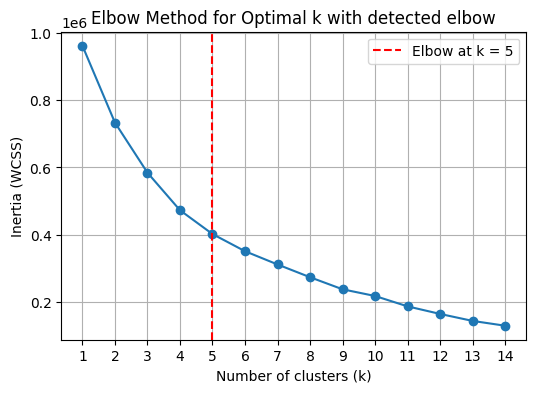

In [ ]:
# Compute inertia scores
inertia_scores = []
K = np.arange(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for reproducibility
    kmeans.fit(df_scaled)
    inertia_scores.append(kmeans.inertia_)

# Detect elbow point for optimal k
knee_locator = KneeLocator(
    K,
    inertia_scores,
    S = 1.0, # Try adjusting S if no elbow found
    curve = 'convex',
    direction = 'decreasing'
)

optimal_k_elbow = knee_locator.elbow

if optimal_k_elbow is not None:
    print(f'\nOptimal k (Elbow Method): {optimal_k_elbow}')
else:
    print('Elbow point not found. Try adjusting sensitivity (S) in KneeLocator.')

# Plot elbow
plt.figure(figsize=(6, 4))
plt.plot(K, inertia_scores, marker = 'o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k with detected elbow')
plt.xticks(K)
plt.grid(True)

if optimal_k_elbow is not None:
    plt.axvline(x = optimal_k_elbow, color = 'r', linestyle = '--', label = f'Elbow at k = {optimal_k_elbow}')
    plt.legend()

plt.show()

The graph above shows a **clear elbow point at k = 5**. This suggests that adding more than 5 clusters provides increasingly smaller gains in reducing the WCSS and that k = 5 captures a significant portion of the data's inherent structure efficiently.

### Silhouette Analysis (Statistical Quality)

I evaluated clustering performance using silhouette scores across multiple k values to identify the number of clusters that best fits the data.


The Silhouette Score continued to increase up to k=9 (from **0.366 at k=5** to **0.493 at k=9**), indicating *slightly* better *statistical separation* *at higher k*.

This suggested that even at k = 9, the clusters, while statistically more distinct, might not be drastically better separated in a way that would fundamentally change their practical interpretation, and may actually **hinder interpretability**. A gain in statistical distinctiveness does not necessarily outweigh the trade-offs of increased complexity in this case.






In [ ]:
k_values = range(2, 10) # k = 1 excluded since silhouette scores can't be computed with 1 cluster
silhouette_scores = []

# Compute silhouette scores for each k
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)
    print(f'k={k} | Silhouette Score: {score:.3f}')

k=2 | Silhouette Score: 0.274
k=3 | Silhouette Score: 0.314
k=4 | Silhouette Score: 0.314
k=5 | Silhouette Score: 0.366
k=6 | Silhouette Score: 0.399
k=7 | Silhouette Score: 0.444
k=8 | Silhouette Score: 0.484
k=9 | Silhouette Score: 0.493


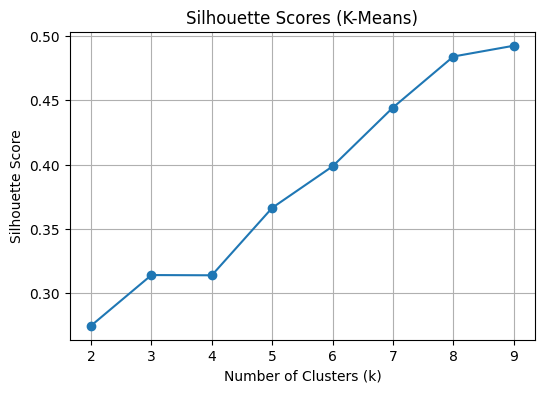

In [ ]:
# Visualize silhouette scores vs. number of clusters (k)
plt.figure(figsize = (6, 4))
plt.plot(k_values, silhouette_scores, marker = 'o')
plt.title('Silhouette Scores (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
# plt.xticks(K)
plt.grid(True)
plt.show()

## 5 Cluster Trial

In [ ]:
# Cluster the data into 5 groups to see if distinct intake clusters emerge
kmeans_5 = KMeans(n_clusters = 5, random_state = 123)
clusters_k5 = kmeans_5.fit_predict(df_scaled)

In [ ]:
# Assign cluster labels back to original df
df['cluster_k5'] = clusters_k5

In [ ]:
# Quick check of cluster sizes
print(df['cluster_k5'].value_counts())

cluster_k5
4    29260
0    18346
2    17067
1    10728
3     4785
Name: count, dtype: int64


In [ ]:
# Assign cluster labels back to numeric
df_numeric_categories['cluster_k5'] = clusters_k5

### Cluster Profiling with Z-score (for Meaningfulness and Interpretability)

This was the most crucial step for identifying meaningful subgroups.

Cluster profiling using Z-scores showed which animal intake traits defined a cluster compared to the overall dataset. This section identified which features stood out the most in each cluster based on standardized Z-scores.
* A high positive Z-score indicates that a feature is a strong driver for that specific cluster, helping to define its individual profile.

---



At k=5, each of the five clusters exhibited distinct and easily interpretable profiles. I was able to clearly identify groups:
* Cluster 0: Fixed, adult, dogs.
* Cluster 1: Intact, mixed-bred strays, primarily cats.
* Cluster 2: Purebred dogs primarily arriving through 'Other' intake methods (ie. owner surrender, public Assists, wildlife, or euthanasia request).
* Cluster 3: Exotics, often with unknown sex, arriving through 'Other' intake methods.
* Cluster 4: Stray kittens, usually intact.

These five profiles are broad enough to be clearly differentiated and actionable for shelter operations.


In [ ]:
# Calculate mean profile per cluster
profile_k5 = df_numeric_categories.groupby('cluster_k5').mean()

# Calculate global mean and std across clusters for Z-score normalization
feature_mean_k5 = profile_k5.mean(axis=0)
feature_std_k5 = profile_k5.std(axis=0).replace(0, np.nan) # Avoid division by 0

# Calculate Z-scores to show top features per cluster
z_scores_k5 = (profile_k5 - feature_mean_k5) / feature_std_k5

# Select top 4 drivers per cluster based on highest Z-scores
N = 4
top_drivers_k5 = {
    cluster: z_scores_k5.loc[cluster].sort_values(ascending=False).head(N).round(2)
    for cluster in z_scores_k5.index
    }

# Display top features per cluster
print('\n --- Top Drivers for k = 5 ---')
for cluster, features in top_drivers_k5.items():
    print(f"\nCluster {cluster}'s Top 4 Drivers (Z-score):")
    print(features.to_string())


 --- Top Drivers for k = 5 ---

Cluster 0's Top 4 Drivers (Z-score):
sex_grouped_Fixed           1.72
age_groupings_Adult         0.56
animal_type_Dog             0.49
breed_binary_Mixed breed    0.23

Cluster 1's Top 4 Drivers (Z-score):
breed_binary_Mixed breed    1.15
intake_type_Stray           0.97
sex_grouped_Intact          0.93
age_groupings_Adult         0.69

Cluster 2's Top 4 Drivers (Z-score):
breed_binary_Pure breed    1.29
animal_type_Dog            1.28
intake_type_Other          0.51
age_groupings_Adult        0.43

Cluster 3's Top 4 Drivers (Z-score):
animal_type_Other          1.79
sex_grouped_Unknown        1.78
intake_type_Other          1.46
breed_binary_Pure breed    0.74

Cluster 4's Top 4 Drivers (Z-score):
age_groupings_Young    1.74
animal_type_Cat        1.30
sex_grouped_Intact     0.80
intake_type_Stray      0.80


## 9 Cluster Trial

In [ ]:
# Compare clustering with k = 9
kmeans_9 = KMeans(n_clusters = 9, random_state = 123)
clusters_k9 = kmeans_9.fit_predict(df_scaled)

In [ ]:
df['cluster_k9'] = clusters_k9
df_numeric_categories['cluster_k9'] = clusters_k9

# Temporary df for k = 9 profiling
df_numeric_categories_for_k9_profile = df_numeric_categories.drop(columns=['cluster_k5'])

### Cluster Profile

At k = 9, each of the nine clusters were *stastistically* more distinct, but the **practical interpretation was muddied**.

* Cluster 0: Fixed, adult, mixed-breed strays.
* Cluster 1: Intact, mixed-breed kittens.
* Cluster 2: Purebred, intact, adult animals.
* Cluster 3: Fixed adult animals arriving through 'Other' intake methods-
* Cluster 4: Exotics, often with unknown sex, primarily arriving through 'Other' intake methods.
* Cluster 5: Purebred, intact puppies.
* Cluster 6: Fixed, purebred animals, primarily adult dogs.
* Cluster 7: Intact, mixed-breed stray dogs.
* Cluster 8: Kittens, primarily mixed-breeds, with unknown sex upon intake.

In [ ]:
# Compute average values per cluster
profile_k9 = df_numeric_categories_for_k9_profile.groupby('cluster_k9').mean()

# Normalize using Z-scores to highlight standout traits
feature_mean = profile_k9.mean()
feature_std = profile_k9.std(axis=0).replace(0, np.nan)

z_scores_k9 = (profile_k9 - feature_mean) / feature_std


# Extract top-N drivers per cluster
N = 4
# Create a dict of top-N standout features per cluster
top_drivers_k9 = {
    cluster: z_scores_k9.loc[cluster].sort_values(ascending=False).head(N).round(2)
    for cluster in z_scores_k9.index
}

# Print top features per cluster
print('\n--- Top Drivers for k = 9 ---')
for cluster, features in top_drivers_k9.items():
    print(f"\nCluster {cluster}'s Top 4 Drivers (Z-score):")
    print(features.to_string())


--- Top Drivers for k = 9 ---

Cluster 0's Top 4 Drivers (Z-score):
sex_grouped_Fixed           1.45
breed_binary_Mixed breed    0.98
age_groupings_Adult         0.92
intake_type_Stray           0.72

Cluster 1's Top 4 Drivers (Z-score):
animal_type_Cat             1.72
age_groupings_Young         1.09
sex_grouped_Intact          1.03
breed_binary_Mixed breed    0.98

Cluster 2's Top 4 Drivers (Z-score):
breed_binary_Pure breed    1.16
sex_grouped_Intact         1.05
age_groupings_Adult        1.01
animal_type_Dog            0.89

Cluster 3's Top 4 Drivers (Z-score):
intake_type_Other      1.86
sex_grouped_Fixed      1.08
age_groupings_Adult    0.75
animal_type_Dog        0.28

Cluster 4's Top 4 Drivers (Z-score):
animal_type_Other          2.67
sex_grouped_Unknown        1.63
intake_type_Other          1.61
breed_binary_Pure breed    0.50

Cluster 5's Top 4 Drivers (Z-score):
age_groupings_Young        1.57
breed_binary_Pure breed    1.16
sex_grouped_Intact         1.05
animal_type_D

### k = 5 vs. 9 Comparison

Many of the k = 9 clusters appear to be subdivisions of the k = 5 groups, differing by only one or two characteristics.

**For example: 'Stray kittens' at** `k = 5` **splitting into ** `k = 9` **groups**
Looking at the k = 5 cluster:
* `k = 5` **Cluster 4: Stray kittens, usually intact.**

This is a clear, meaningful subgroup. It allows the shelter to take immediate action.   
* Unsterilized stray cats need fostering, spay/neutering surgery, or possible immediate medical attention.

---


Now, let's look at how this group is split at `k = 9`:
* k = 9 Cluster 1: Intact, mixed-breed kittens.
* k = 9 Cluster 8: Kittens, primarily mixed-breeds, with unknown sex upon intake.


Both Cluster 1 and Cluster 8 are comprised of mixed breed kittens. The main characteristic that separates them is the sex_upon_intake:
* Cluster 1 is 'Intact'
* Cluster 8 is 'Unknown' reproductive status.


---


For shelter operations, while 'unknown sex' might require a quick follow up assessment, the *strategic implications* for inital management of these two groups of kittens are **overall, the same**: they both need immediate evaluation for spay/neutering, fostering, vaccinations, and are susceptible to illness. So, while statistically separable, a distinction based solely on `sex_grouped_Unknown` doesn't require a real change in operations approach for shelter staff. This pattern of fine subdivision was found across several of the additional clusters at `k = 9`.


> Therefore, **k = 5 was selected as the optimal number of cluster**s because it offered a better balance between statistical insight and actionable steps.



## Cluster Evaluation & Interpretation

### Heatmap of Cluster Profiles

To further visualize what defines each cluster at k = 5, I have provided a cluster profiles heatmap.

*   *Rows* represent simplified, one-hot encoded features
*   *Columns* represent the discovered clusters

Darker hues of blue indicate higher expression of a feature within that cluster. For example, Cluster 3 is the only group with exotics. They often arrive through 'Other' intake methods and with unknown sex.


---

Being able to visualize these clusters allow the animal shelter to interpretable groupings and help them plan practical next steps (will discuss further in Final Review section)





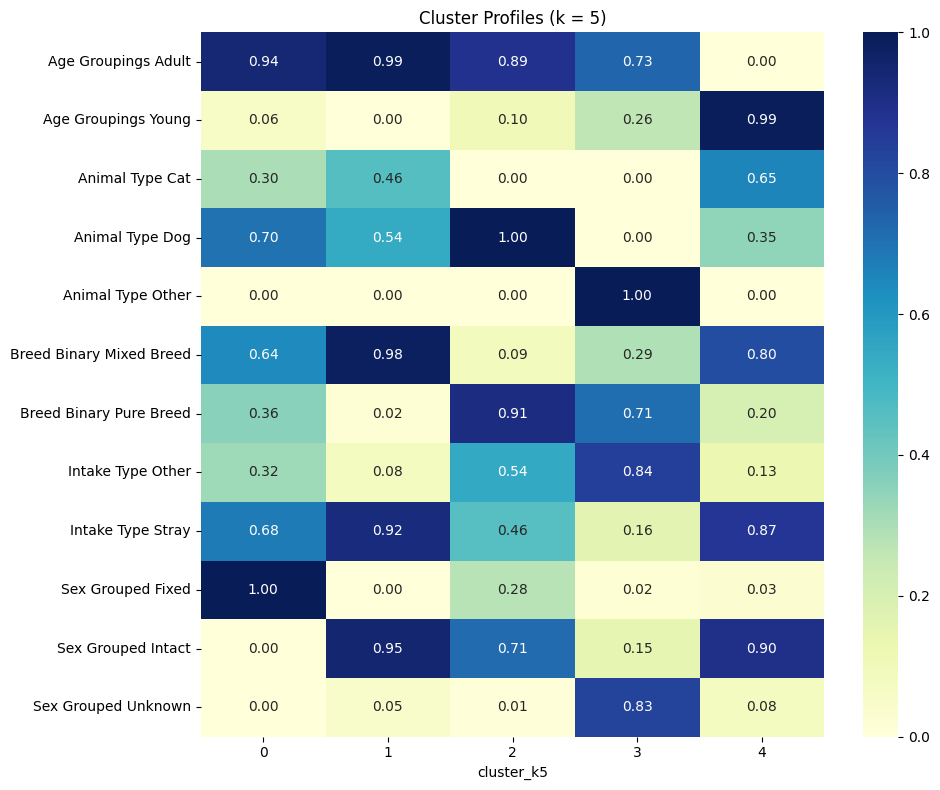

In [ ]:
# Prepare for k = 5 profiling
df_numeric_categories_for_k5_profile = df_numeric_categories.drop(columns=['cluster_k9'], errors='ignore')

# Profile by cluster
profile_k5 = df_numeric_categories_for_k5_profile.groupby('cluster_k5').mean()

# Drop features that are very close to 0 across all clusters and likely uninformative
low_avg_cols = profile_k5.mean(axis = 0)[profile_k5.mean(axis = 0) < 0.01].index
profile_reduced = profile_k5.drop(columns = low_avg_cols)

# Transpose features (rows) and clusters (columns)
profile_reduced_T = profile_reduced.T

# Format feature labels for readability
profile_reduced_T.index = [label.replace('_', ' ').title() for label in profile_reduced_T.index]
profile_reduced_T = profile_reduced_T.sort_index()

# Plot heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(profile_reduced_T, cmap = "YlGnBu", annot = True, fmt=".2f")
plt.title('Cluster Profiles (k = 5)')
plt.tight_layout()
plt.show()

### Threshold-Based Feature Relevance Assessment

Threshold review of features to assess signal strength across clusters.

Defined high and low expression thresholds (0.7 and 0.1 respectively) and used them to assess how well features contributed to cluster distinction.

* Features with no values >0.1 were considered uninformative and dropped or regrouped.


In [ ]:
# Define thresholds for features
high_threshold = 0.7   # Feature strongly present in at least one cluster
low_threshold = 0.1    # Feature consistently low across all clusters

strong_features = []
uninformative_features = []
borderline_features = []

for feature in profile_reduced_T.index:
    values = profile_reduced_T.loc[feature]
    if (values > high_threshold).any():
        strong_features.append(feature)
    elif (values < low_threshold).all():
        uninformative_features.append(feature)
    else:
        borderline_features.append(feature)

print('Strong features:', strong_features)
print('Uninformative features:', uninformative_features)
print('Review features:', borderline_features)

Strong features: ['Age Groupings Adult', 'Age Groupings Young', 'Animal Type Dog', 'Animal Type Other', 'Breed Binary Mixed Breed', 'Breed Binary Pure Breed', 'Intake Type Other', 'Intake Type Stray', 'Sex Grouped Fixed', 'Sex Grouped Intact', 'Sex Grouped Unknown']
Uninformative features: []
Review features: ['Animal Type Cat']


Though cats appear to be a borderline feature, this feature was ultimately retained for sake of completeness.

## Final Review & Summary

In this project, I used K-Means clustering to identify meaningful subgroups amongst animals based on their intake traits.

Initially, I utilized both the elbow method and silhouette scores to speculate optimal k. After clustering with both k = 5 (from elbow method) and k = 9 (from silhouette scores over k), and comparing what features drove each cluster, I ultimately decided that k = 5 would provide clearer interpretation and most importantly, offer actionable next steps for shelter staff.

Overall, this project helped me in segmenting the data, identifying top intake features, and lay the foundation for continued cluster analysis.

## Limitations

* Cluster quality depends on **available features** in the Austin Animal Center intake dataset. Provided additional data could unveil finer distinctions.
* **K-Means is responsive to initial centroids** and assumes spherical clusters. Even though `random_state` was used, other algorithms might display different underlying structures.

# Future Work & Recommendations




These findings highlight important areas for future work:

* **Explore Alternative Clustering Methods**: Try density-based algorithms (like DBSCAN) to see if this reveals similar, or very different groups.

* **Feature Engineering Enhancement:** Deeper feature engineering, especially for contextual data (ie. `found_location`), could provide more nuanced insights.

* **Practical maneuvers:** These clusters offer opportunities for the Austin Animal Center to develop targeted strategies. For example, specific protocols or resource allocation could be tailored for groups dominated by stray kittens vs. exotics with little background information.

Overall, this cluster set provides a solid foundation for in depth study and future modeling.